# Deep Koopman Autoencoder

This notebook investigates the deep koopman autoencoder and how to train it.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics, plot_avg
from koopmag.data_utils import train_test_split
from koopmag.koopman_model import DeepKoopman, KoopmanAE

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "1000_150_40_16.h5", "r")
    print("Successfully loaded data")

    print("Attributes of database:")
    for key in db.attrs:
        print(f"{key}: {db.attrs[key]}")

    print("\nData in the database:")
    for key in db:
        print(f"{key}: {db[key].shape}")

    # extract external fields
    Hs = np.array(db["field"])

    # extract data
    DATA = np.array(db["sequence"])
    db.close()

except FileNotFoundError:
    print("Database not found. Please try again.")

Successfully loaded data
Attributes of database:
grid_size: [5.e-07 2.e-07 3.e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [40 16  1]
seed: 0
t_per_step: 1.5e-11
t_steps: 150

Data in the database:
field: (1000, 3)
sequence: (1000, 150, 40, 16, 3)


In [4]:
test_size = 0.2
window_size = 32
step = 1
seed = 1
batch_size = 16

train_dataset, test_dataset, train_indices, test_indices = train_test_split(X=DATA, 
                                                                Hs=Hs, 
                                                                dataset_type="window",
                                                                test_size=test_size, 
                                                                window_size=window_size, 
                                                                step=step,
                                                                seed=seed)

print(f"samples in train set: {len(train_dataset)}, samples in test set: {len(test_dataset)}")

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

samples in train set: 95200, samples in test set: 23800


In [11]:
og_batch_size = 12

og_train, og_test, train_idx, test_idx = train_test_split(X=DATA,
                                           Hs=Hs, 
                                           dataset_type="full",
                                           test_size=test_size, 
                                           window_size=window_size, 
                                           step=step,
                                           seed=seed)

og_trainloader = DataLoader(og_train, batch_size=og_batch_size, shuffle=True)
og_testloader = DataLoader(og_test, batch_size=og_batch_size, shuffle=False)

print(f"og train samples: {len(og_train)}, og test samples: {len(og_test)}")

og train samples: 96, og test samples: 24


In [5]:
assert torch.all(train_indices == train_idx), "Indices of training set do not match"
assert torch.all(test_indices == test_idx), "Indices of test set do not match"

### Koopman Autoencoder

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chns = [256, 128, 64]
latent_dim = 64
act_fn = nn.Tanh

ae = KoopmanAE(chns=chns, latent_dim=latent_dim, act_fn=act_fn).to(device)

dummy_data = torch.randn(10, 32, 40, 16, 3).to(device)
dummy_out = ae(dummy_data)

assert dummy_out.shape == dummy_data.shape, f"Output shape {dummy_out.shape} does not match input shape {dummy_data.shape}"

In [30]:
optimizer = optim.Adam(ae.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

epochs = 20
valid_every = 2
train_loss = np.zeros(epochs)
valid_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for (xtrain, _) in trainloader:

        xtrain = xtrain.to(device)

        ae.train()
        optimizer.zero_grad()

        # forward pass
        yhat = ae(xtrain)

        # compute loss
        loss = loss_fn(yhat, xtrain)
        
        # backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_loss[epoch] = running_loss / len(trainloader)

    if epoch % valid_every == valid_every - 1:
        ae.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for (xtest, _) in testloader:
                xtest = xtest.to(device)
                yhat = ae(xtest)
                v_loss = loss_fn(yhat, xtest)
                running_loss_val += v_loss.item()
            valid_loss.append(running_loss_val / len(testloader))

        print(f"Epoch {epoch+1}/{epochs}, training loss: {train_loss[epoch]:.4f}, validation loss: {valid_loss[-1]:.4f}")

Epoch 2/20, training loss: 0.0130, validation loss: 0.0112
Epoch 4/20, training loss: 0.0075, validation loss: 0.0067
Epoch 6/20, training loss: 0.0053, validation loss: 0.0056
Epoch 8/20, training loss: 0.0042, validation loss: 0.0047
Epoch 10/20, training loss: 0.0035, validation loss: 0.0042
Epoch 12/20, training loss: 0.0030, validation loss: 0.0038
Epoch 14/20, training loss: 0.0028, validation loss: 0.0040
Epoch 16/20, training loss: 0.0025, validation loss: 0.0034
Epoch 18/20, training loss: 0.0023, validation loss: 0.0032
Epoch 20/20, training loss: 0.0021, validation loss: 0.0030


In [34]:
torch.save(ae.state_dict(), datapath / "ae_weights.pth")

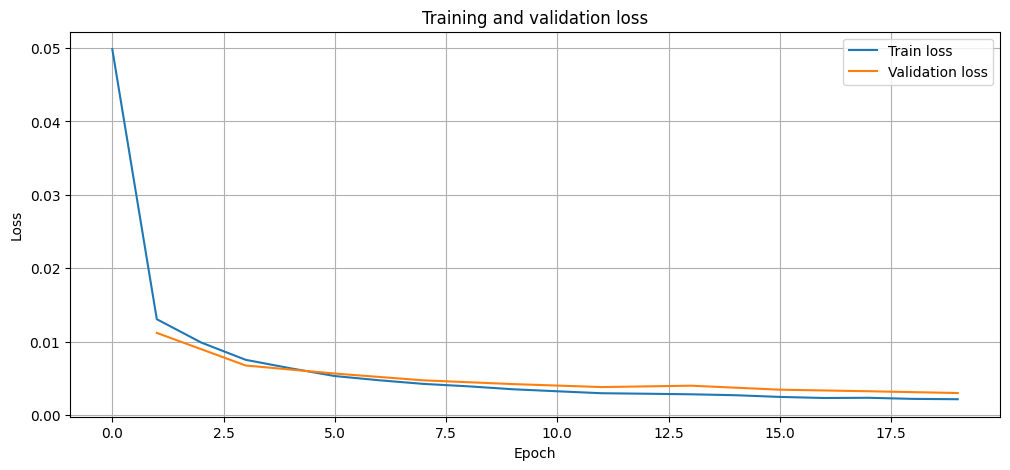

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_loss, label="Train loss")
ax.plot(np.arange(valid_every - 1, epochs, valid_every), valid_loss, label="Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and validation loss")
ax.legend()
ax.grid()
plt.show()

In [7]:
ae.load_state_dict(torch.load(datapath / "ae_weights.pth", weights_only=True))

<All keys matched successfully>

In [32]:
ae.eval()

data_rec = []
with torch.no_grad():
    for (xtest, _) in og_testloader:
        xtest = xtest.to(device)
        yhat = ae(xtest)
        data_rec.append(yhat.cpu().numpy())

data_rec = np.concatenate(data_rec, axis=0)
data_rec.shape

(24, 150, 40, 16, 3)

Field index: 0


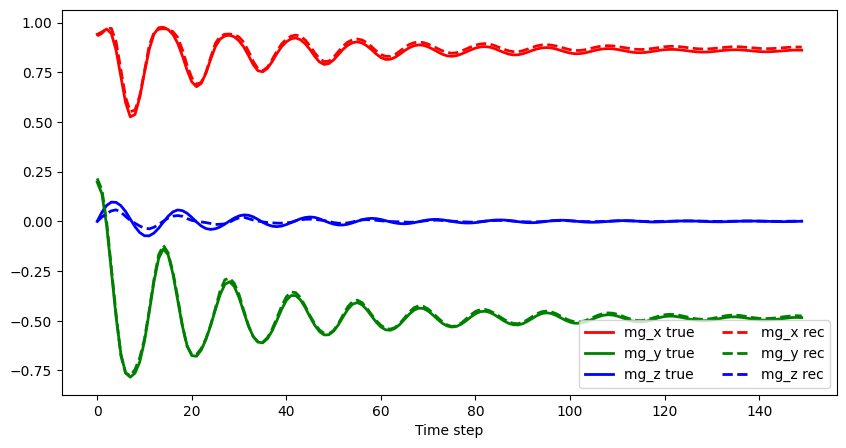

In [33]:
field_idx = 0

print(f"Field index: {field_idx}")
fig, ax = plt.subplots(figsize=(10, 5))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(data_rec[field_idx], ax, linestyle="--", annot="rec")
ax.set_xlabel("Time step")
plt.show()

In [19]:
LEARN_A = True

koopman = DeepKoopman(
    chns=chns,
    latent_dim=latent_dim,
    act_fn=act_fn,
    learn_A=LEARN_A,
    method="tikh",
    lam=5.
    ).to(device)

#koopman.autoencoder.load_state_dict(torch.load(datapath / "ae_weights.pth", weights_only=True))

In [20]:
dummy_X = torch.ones((20, 50, 40, 16, 3)).to(device)
dummy_U = torch.ones((20, 50, 3)).to(device)

x_dummy, y_dummy = koopman(dummy_X, dummy_U)
print(x_dummy.shape, y_dummy.shape)
pred_dummy = koopman.predict(dummy_X[:, 0, :, :, :], dummy_U)
print(pred_dummy.shape)
del dummy_X, dummy_U, x_dummy, y_dummy

torch.Size([20, 49, 40, 16, 3]) torch.Size([20, 49, 40, 16, 3])
torch.Size([20, 51, 40, 16, 3])


In [21]:
optimizer = optim.Adam(koopman.parameters(), lr=1e-3)
criterion = nn.MSELoss()

lr_scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 1
valid_every = 1
n_rep = 1

train_loss = np.zeros(epochs)
valid_loss = []

for epoch in range(epochs):

    running_loss = 0.0
    for (xtrain, utrain) in trainloader:
        
        xtrain, utrain = xtrain.to(device), utrain.to(device)

        koopman.train()
        optimizer.zero_grad()

        xhat, yhat = koopman(xtrain,  U=utrain)

        loss = criterion(xhat, xtrain[:,:-1,:,:,:]) + criterion(yhat, xtrain[:,1:,:,:,:])

        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
    
    train_loss[epoch] = running_loss / len(trainloader)
    lr_scheduler.step()

    if epoch % valid_every == valid_every - 1:
        koopman.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for (xtest, utest) in testloader:

                xtest, utest = xtest.to(device), utest.to(device)

                xhat, yhat = koopman(xtest, U=utest)

                v_loss = criterion(xhat, xtest[:,:-1,:,:,:]) + criterion(yhat, xtest[:,1:,:,:,:])
                running_loss_val += v_loss.item()
            valid_loss.append(running_loss_val / len(testloader))
        print(f"Epoch {epoch+1}, Training loss: {train_loss[epoch]:.4f}, Validation Loss: {valid_loss[-1]:.4f}, LR: {lr_scheduler.get_last_lr()[0]:.3e}")

Epoch 1, Training loss: 0.0526, Validation Loss: 0.0248, LR: 1.000e-03


In [ ]:
#torch.save(koopman.state_dict(), datapath / "koopman_weights.pth")

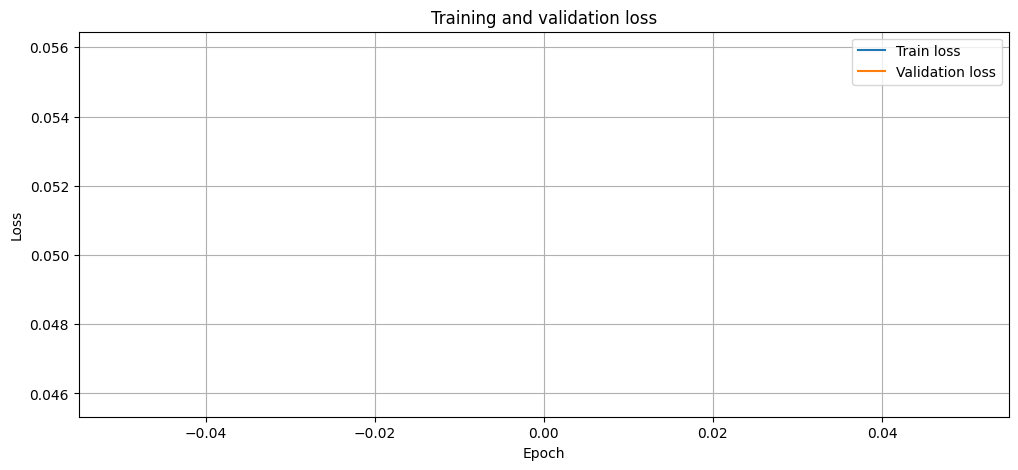

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train_loss, label="Train loss")
ax.plot(np.arange(valid_every - 1, epochs, valid_every), valid_loss, label="Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and validation loss")
ax.legend()
ax.grid()
plt.show()

In [26]:
koopman.load_state_dict(torch.load(datapath / "koopman_full.pth", weights_only=True))
koopman = koopman.to(device)    

In [27]:
koopman.eval()

Ypreds = []
with torch.no_grad():
    for (xtest, utest) in og_testloader:
        xtest, utest = xtest.to(device), utest.to(device)
        yhat = koopman.predict(xtest[:, 0, :, :, :], utest)
        Ypreds.append(yhat.detach().cpu().numpy())

Ypreds = np.concatenate(Ypreds, axis=0)

In [28]:
Ypreds.shape

(24, 151, 40, 16, 3)

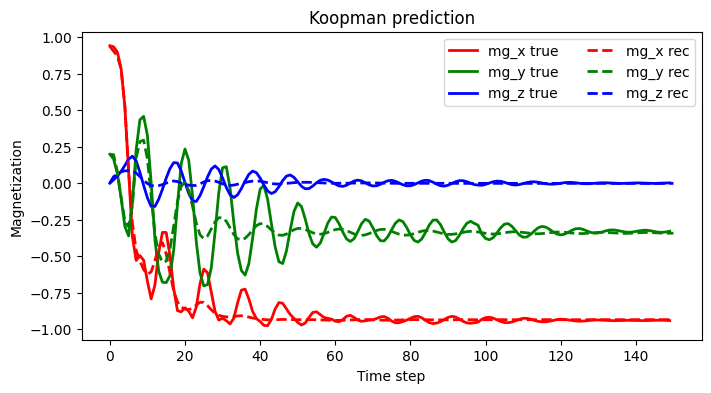

In [32]:
field_idx = 5

fig, ax = plt.subplots(figsize=(8, 4))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Koopman prediction")
plt.show()

In [24]:
koopman.eval()

Xrec = []
with torch.no_grad():
    for (xtest, _) in og_testloader:
        xtest = xtest.to(device)
        xhat = koopman.autoencoder(xtest)
        Xrec.append(xhat.detach().cpu().numpy())

del xtest
Xrec = np.concatenate(Xrec, axis=0)

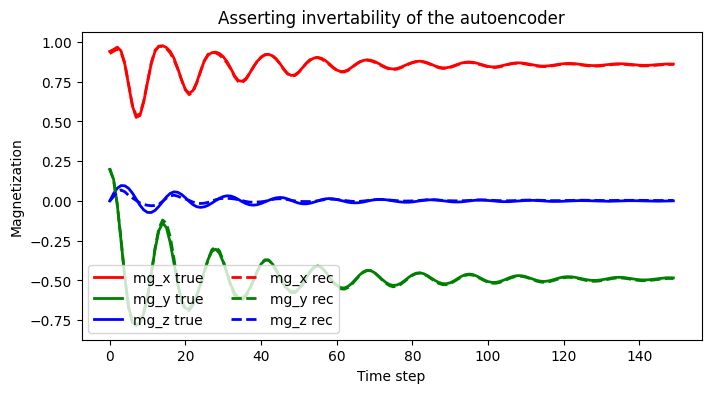

In [27]:
field_idx = 0

fig, ax = plt.subplots(figsize=(8, 4))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Xrec[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Asserting invertability of the autoencoder")
plt.show()

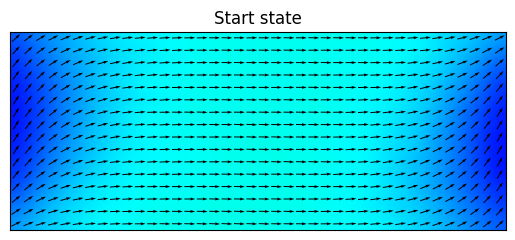

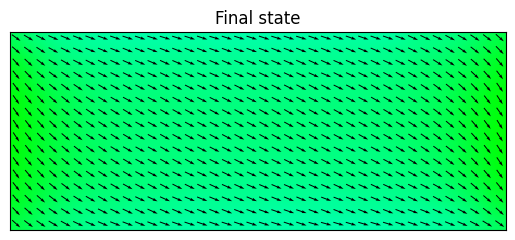

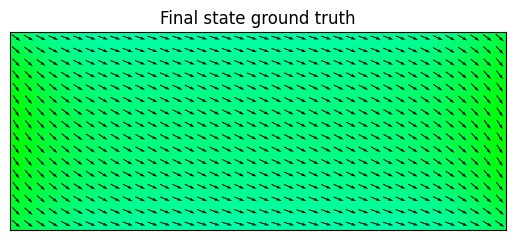

In [28]:
res = np.array([40, 16, 1])

plot_M_thin_film(Ypreds[field_idx][0], res, "Start state")
plot_M_thin_film(Ypreds[field_idx][-1], res, "Final state")
plot_M_thin_film(DATA[test_indices[field_idx]][-1], res, "Final state ground truth")